In [1]:
# sklearn utilties 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# classifiers  
from sklearn.linear_model import LogisticRegression
# from sklearn.dummy import DummyClassifier
# from sklearn.ensemble import RandomForestClassifier

# sampling 
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# useful libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# more lib
import os, sys
import dropbox
from zipfile import ZipFile
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
from utils.data_extract_utils import extract_zip, extract_features_from_bureau, get_clean_credit, remove_highly_correlated_columns,extract_features_from_installments_payments
import gc



Bad key "text.kerning_factor" on line 4 in
/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# helper functions
def get_missing_data_info(df):
    """
    add description .. 
    
    """
    num_of_instance, _ = df.shape
    #print(num_of_instance)
    names = {'index': 'feature', 
             0: 'PERC_missing_data'}
    
    missing_df = (df.isnull() \
        .sum(axis=0)/num_of_instance) \
        .to_frame() \
        .reset_index() \
        .rename(columns=names) \
        .sort_values(by='PERC_missing_data', ascending=False) \
        .reset_index(drop=True)
    
    d = {}
    # no missing 
    zero = missing_df[missing_df['PERC_missing_data'] == 0]
    d['x = 0'] = list(zero.feature)
    le_10 = missing_df[(missing_df['PERC_missing_data'] > 0.0) & (missing_df['PERC_missing_data'] <= 0.1)]
    
    d['0< x <= 25'] = list(missing_df[(missing_df['PERC_missing_data'] > 0.0) & (missing_df['PERC_missing_data'] <= 0.25)].feature)
    
    d['25 < x <= 50'] = list(missing_df[(missing_df['PERC_missing_data'] > 0.25) & (missing_df['PERC_missing_data'] <= 0.5)].feature)
    
    d['x > 50'] = list(missing_df[missing_df['PERC_missing_data'] > 0.5].feature)
    
    return missing_df, d

def combine(x):
    if x == "Incomplete higher" or x == 'Academic degree':
        return 'Higher education'
    elif x == 'Lower secondary':
        return 'Secondary / secondary special'
    else:
        return x
    
def get_columns_x(application, col_name, threshhold):
    temp = application.loc[:, col_name].value_counts(dropna=False).to_frame().reset_index()
    temp.columns = ['values', 'count']
    temp['prec of val'] = temp['count'].apply(lambda x: x/application.shape[0])
    groups = list(temp.loc[temp['prec of val'] <threshhold, 'values'].values)
    
    return groups

def corr_with_target(application):
    target = application.loc[application['TARGET'].notnull(), 'TARGET']
    train_df = application.loc[application['TARGET'].notnull(), :].drop(columns=['TARGET']).select_dtypes(include = [int, float])

    corr_col = [i for i in train_df.columns if i not in ['index', 'SK_ID_CURR']]
    corr_arr = pd.Series([target.corr(train_df[i]) for i in corr_col])
    
    name = pd.Series(corr_col)
    df_dict = {'feature': name, 'corr with target': corr_arr}
    corr_df = pd.DataFrame(df_dict).sort_values(by = 'corr with target',ascending=False)
    
    return corr_df

def clean_application(data):

    # get table 
    application = data['application_train'].copy().append(data['application_test']).reset_index()
    
    # fix categorical data 

    # 'NAME_TYPE_SUITE'
    application.replace({'NAME_TYPE_SUITE': ['Children', 
                                             'Other_B', 
                                             'Other_A', 
                                             'Group of people']}, 
                        'Other', inplace = True)


    # 'NAME_INCOME_TYPE'
    application.replace({'NAME_INCOME_TYPE': ['Unemployed', 
                                              'Student', 
                                              'Businessman', 
                                              'Maternity leave']}, 
                        'Other', inplace=True)

    # NAME_EDUCATION_TYPE
    application['NAME_EDUCATION_TYPE'] = application['NAME_EDUCATION_TYPE'].apply(lambda x: combine(x))

    #'NAME_HOUSING_TYPE'
    application.replace({'NAME_HOUSING_TYPE': ['Municipal apartment', 
                                               'Office apartment', 
                                               'Co-op apartment']}, 
                        'Rented apartment', inplace = True)

    # OCCUPATION_TYPE
    other_occp = get_columns_x(application, 'OCCUPATION_TYPE', 0.03)  
    application.replace({'OCCUPATION_TYPE': other_occp}, 
                        'Other', inplace = True)

    # ORGANIZATION_TYPE
    other_org = get_columns_x(application, 'ORGANIZATION_TYPE', 0.02)  
    application.replace({'ORGANIZATION_TYPE': other_org}, 
                        'Other', inplace = True)

    # drop cat features - low variance and high % of missing val
    application.drop(columns = ['FONDKAPREMONT_MODE', 
                                'HOUSETYPE_MODE', 
                                'WALLSMATERIAL_MODE', 
                                'EMERGENCYSTATE_MODE'], 
                     axis = 1, inplace=True)

    ## label encoder for binary values
    bin_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

    replace_dict = {'CODE_GENDER': {'M': 0, 'F': 1},
                    'FLAG_OWN_CAR': {'Y': 0, 'N': 1}, 
                    'FLAG_OWN_REALTY':{'Y': 0, 'N': 1},
                   'NAME_EDUCATION_TYPE': {'Higher education': 1,
                                          'Secondary / secondary special': 0}}

    application.replace(replace_dict, inplace=True)


    # remove few instances with low appearance
    application = application.loc[application['CODE_GENDER'] != 'XNA', :]
    application = application.loc[application['NAME_FAMILY_STATUS'] != 'Unknown', :]


    # drop_features > 50% of missing vals (both: cat, num)
    cols = [i for i in list(application.columns) if i != 'TARGET']
    _, missing_dict = get_missing_data_info(application.loc[:,cols])
    drop_cols = missing_dict['x > 50']

    # keep EXT_SOURCE_1 --> highly corr with target 
    drop_cols.remove('EXT_SOURCE_1')
    application.drop(columns = drop_cols, axis = 1, inplace = True)

    # Numerical features 

    ## DAYS_EMPLOYED
    application['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    application['DAYS_EMPLOYED'] =application['DAYS_EMPLOYED'].apply(lambda x: abs(x))

    application['BIRTH_IN_YEARS'] = application['DAYS_BIRTH'].apply(lambda x: abs(x)/365)


    # add new features 
    application['ALL_EXT_SOURCE_MEAN']=application[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    application['PAYMENT_RATE'] = application['AMT_ANNUITY']/application['AMT_CREDIT']
    application['INCOME_PER_PERSON'] = application['AMT_INCOME_TOTAL']/application['CNT_FAM_MEMBERS']
    application['INCOME_CREDIT_IN_PERCENTAGE '] = application['AMT_INCOME_TOTAL']/application['AMT_CREDIT']
    application['ANNUITY_INCOME_IN_PERCENTAGE'] = application['AMT_ANNUITY']/application['AMT_INCOME_TOTAL']

    doc_cols = [i for i in list(application.columns) if 'FLAG_DOCUMENT' in i]
    application['ALL_FLAG_DOCUMENT_SUM']=application[doc_cols].mean(axis = 1)

    ## drop indiv doc columns + other useless columns 
    application.drop(columns = doc_cols, axis = 1, inplace = True)
    application.drop(columns = ['FLAG_CONT_MOBILE','FLAG_MOBIL', 'DAYS_BIRTH'], axis = 1, inplace = True)
    

    if 'index' in list(application.columns):
        application.drop(columns = ['index'], axis = 1, inplace = True)
        print('index column removed')

    return application

def join_tables(data):
    # credit card table
    cc = get_clean_credit(data['credit_card_balance'])
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
    cc_agg.columns = pd.Index(list(map(lambda x: 'CC' + '_' + x[0] + '_' + x[1], list(cc_agg.columns))))
    
    # main aplication 
    train_test = clean_application(data)
    train_test.set_index('SK_ID_CURR', inplace=True, drop=False)
    
    # burea/balance table
    bb = extract_features_from_bureau(data['bureau'], data['bureau_balance'])
    
    # isntallments payments table
    ip = extract_features_from_installments_payments(data['installments_payments'])
    
    # join table
    df = pd.concat([train_test, bb, ip, cc_agg], axis=1) 
    df = df.reset_index(drop=True)
    df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('Int64')
    
    # clean memory
    del cc
    del cc_agg
    del train_test
    del bb
    del ip
    gc.collect()
    
    return df


In [3]:
# Connect to dropbox
dbx = dropbox.Dropbox('cHV7yAR0J6YAAAAAAAAAAVQ1NLCrOwerbaNltPWHslYXKuUTJ5_wfgJsuFcmx83o')

data = {}
for entry in dbx.files_list_folder('').entries:
    response = dbx.files_download('/{}'.format(entry.name))
    
    if 'zip' in entry.name:
        content = extract_zip(response[1].content)
    
        for file in content:
            df = pd.read_csv(file[1])
            data[entry.name.replace('.csv.zip', '')] = df
            


In [4]:
main_df = join_tables(data)
main_df.shape

/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_SUM'] = dpd_counts_sum['SK_DPD']
/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']


index column removed


(356254, 104)

In [5]:
X, y = (main_df.loc[(main_df['TARGET'].notnull()) & (main_df['SK_ID_CURR'].notnull()), :].drop(columns=['TARGET', 'SK_ID_CURR'], axis=1), 
        main_df.loc[(main_df['TARGET'].notnull()) & (main_df['SK_ID_CURR'].notnull()), 'TARGET'])

# test set for kaggle
test_ids = main_df.loc[(main_df['TARGET'].isnull()) & (main_df['SK_ID_CURR'].notnull()), 'SK_ID_CURR']
X_test = main_df.loc[(main_df['TARGET'].isnull()) & (main_df['SK_ID_CURR'].notnull()), :].drop(columns=['TARGET', 'SK_ID_CURR'], axis=1)

In [6]:
X.shape, y.shape

((307505, 102), (307505,))

In [7]:
test_ids.shape, X_test.shape

((48744,), (48744, 102))

In [8]:
cat_cols = list(X.select_dtypes(include=object).columns)
num_cols = list(X.select_dtypes(include=[int, float]).columns)
len(cat_cols),len(num_cols)

(9, 93)

In [9]:
## pipelines

# one hot encoding 
categorical_pipe = Pipeline(steps=[
    ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
  ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# numerical 
numerical_pipe = Pipeline(steps=[
    ('num_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ("scale", StandardScaler())  
])


# transform columns 
column_transformer = ColumnTransformer(transformers=[    
    ('num_pip', numerical_pipe, num_cols),
    ('cat_pipe', categorical_pipe, cat_cols)
])

In [10]:
# apply preprocessing to X
X_trans = column_transformer.fit_transform(X)

In [14]:
# smote sampling
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_trans,y)

X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)
logreg= LogisticRegression(solver='lbfgs', random_state=42,max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred_val = logreg.predict(X_val)
print('classifaction report on training set')
print(classification_report(y_train, y_pred_train, labels=[0,1]))
print('--------------------------------------------------------------')
print('classifaction report on validation set')
print(classification_report(y_val, y_pred_val, labels=[0,1]))

classifaction report on training set
              precision    recall  f1-score   support

           0       0.71      0.70      0.70    226144
           1       0.70      0.71      0.71    226144

    accuracy                           0.71    452288
   macro avg       0.71      0.71      0.71    452288
weighted avg       0.71      0.71      0.71    452288

--------------------------------------------------------------
classifaction report on validation set
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     56536
           1       0.70      0.71      0.71     56536

    accuracy                           0.71    113072
   macro avg       0.71      0.71      0.71    113072
weighted avg       0.71      0.71      0.71    113072



In [15]:
from sklearn.metrics import plot_roc_curve

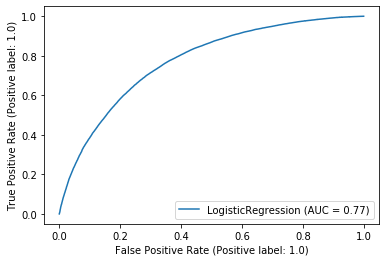

In [16]:
plot_roc_curve(logreg, X_val, y_val,)
plt.show()

In [12]:
X_test_trans = column_transformer.transform(X_test)
logreg_test_pred = logreg.predict_proba(X_test_trans )[:,1]

submission6_dict = {'SK_ID_CURR': test_ids, 
            'TARGET': logreg_test_pred }
logreg_submission6 = pd.DataFrame(submission6_dict)
logreg_submission6.head()

,SK_ID_CURR,TARGET
0,100001,0.485330
4,100005,0.738758
12,100013,0.220487
27,100028,0.186892
37,100038,0.667689


In [13]:
#logreg_submission6.to_csv('submission6.csv', index=False) # 74.36%

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
# apply preprocessing to X
X_trans = column_transformer.fit_transform(X)
X_test_trans = column_transformer.transform(X_test)

# smote sampling
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_trans,y)

X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)

In [13]:
grid={"C":[1/10, 5, 50, 100], "penalty":["l1","l2"]}
logreg=LogisticRegression(max_iter=1000, random_state=42)
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)
print("best tuned hpyerparameters: ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/mod

/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/eyobmanhardt/opt/anaconda3/lib/python3.7/site-packages/sklearn/lin

KeyboardInterrupt: 

In [ ]:
# get column names

In [74]:
def join_tables_2(data):
    # credit card table
    cc = get_clean_credit(data['credit_card_balance'])
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
    cc_agg.columns = pd.Index(list(map(lambda x: 'CC' + '_' + x[0] + '_' + x[1], list(cc_agg.columns))))
    
    # main aplication 
    train_test = clean_application(data)
    train_test.set_index('SK_ID_CURR', inplace=True, drop=False)
    
    # burea/balance table
    bb = extract_features_from_bureau(data['bureau'], data['bureau_balance'])
    
    # isntallments payments table
    ip = extract_features_from_installments_payments(data['installments_payments'])
    
    # join table
    df = pd.concat([train_test, bb, ip, cc_agg], axis=1) 
    df = df.reset_index(drop=True)
    df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('Int64')
    df = df.loc[df['SK_ID_CURR'].notnull(), :]
    
    # clean memory
    del cc
    del cc_agg
    del train_test
    del bb
    del ip
    gc.collect()
    
    return df

def clean(df):
    cols = [i for i in list(df.columns) if i != 'TARGET']

    before = set(list(df[cols].columns))

    df_ohe = pd.get_dummies(df.loc[:, cols])

    after = set(list(df_ohe.columns))
    diff = after.difference(before)

    # more cat cols
    more_cols = [i for i in list(df_ohe.columns) if (i not in diff and df_ohe[i].nunique() < 25)]

    # impute cat
    cat_like_cols = more_cols + list(diff)
    values = dict(map(lambda x: (x,df_ohe.loc[:, x].mode()[0]), cat_like_cols))
    df_ohe.fillna(value=values, inplace=True)

    # impute num
    num_like_cols = [i for i in list(df_ohe.columns) if i not in cat_like_cols + ['TARGET', 'SK_ID_CURR']]
    val = dict(map(lambda x: (x,df_ohe.loc[:, x].median()), num_like_cols))
    df_ohe.fillna(value=val, inplace=True)
    
    return df_ohe, num_like_cols, cat_like_cols


In [65]:
# pipeline

pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression(solver='lbfgs', random_state=42,max_iter=1000), )
])

In [67]:
final_df = join_tables_2(data)

/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_SUM'] = dpd_counts_sum['SK_DPD']
/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']


index column removed


In [ ]:
y = final_df.loc[final_df['TARGET'].notnull(), 'TARGET']

In [70]:
y.shape, final_df.shape

((307505,), (356249, 104))

In [75]:
final_df_clean, num_like_cols, cat_like_cols = clean(final_df)

In [77]:
X = final_df_clean.loc[final_df['TARGET'].notnull(), :].drop(columns=['SK_ID_CURR'], axis=1)
       

# test set for kaggle
test_ids = final_df_clean.loc[final_df['TARGET'].isnull(), 'SK_ID_CURR']
X_test = final_df_clean.loc[final_df['TARGET'].isnull(), :].drop(columns=['SK_ID_CURR'], axis=1)

In [78]:
X.shape, X_test.shape, test_ids.shape 

((307505, 140), (48744, 140), (48744,))

In [80]:
# smote sampling
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)

# X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state= 42, stratify=y_sm)
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))])

In [87]:
feature_importance = pipe.named_steps['logreg'].coef_.T.reshape((140,))

In [88]:
feature_importance.shape

(140,)

In [89]:
y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)
print('classifaction report on training set')
print(classification_report(y_train, y_pred_train, labels=[0,1]))
print('--------------------------------------------------------------')
print('classifaction report on validation set')
print(classification_report(y_val, y_pred_val, labels=[0,1]))

classifaction report on training set
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226144
           1       1.00      0.91      0.95    226144

    accuracy                           0.95    452288
   macro avg       0.96      0.95      0.95    452288
weighted avg       0.96      0.95      0.95    452288

--------------------------------------------------------------
classifaction report on validation set
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56536
           1       1.00      0.91      0.95     56536

    accuracy                           0.95    113072
   macro avg       0.96      0.95      0.95    113072
weighted avg       0.96      0.95      0.95    113072



In [90]:
logreg_test_pred = pipe.predict_proba(X_test)[:,1]

submission7_dict = {'SK_ID_CURR': test_ids, 
            'TARGET': logreg_test_pred }
logreg_submission7 = pd.DataFrame(submission7_dict)
logreg_submission7.head()

,SK_ID_CURR,TARGET
0,100001,0.071279
4,100005,0.153105
12,100013,0.139751
27,100028,0.019854
37,100038,0.145650


In [91]:
X.shape

(307505, 140)

In [30]:
dd = join_tables_2(data)

/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_SUM'] = dpd_counts_sum['SK_DPD']
/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']


index column removed


In [31]:
cols = [i for i in list(dd.columns) if i != 'TARGET']

In [32]:
dont_crash = pd.get_dummies(dd.loc[:, cols])

In [33]:
dont_crash.head()

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA
0,100001,1.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,1.0,0.018850,...,0,0,0,1,0,0,0,0,0,0
1,100002,1.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.0,0.018801,...,1,0,0,0,0,0,0,0,0,0
2,100003,1.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,1.0,0.003541,...,0,0,0,0,0,0,1,0,0,0
3,100004,0.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.0,0.010032,...,0,0,1,0,0,0,0,0,0,0
4,100005,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,0.035792,...,0,0,0,0,0,0,0,1,0,0


In [44]:
dont_crash['FLAG_OWN_CAR'].value_counts().argmax()

0

In [45]:
dont_crash['FLAG_OWN_CAR'].value_counts()

1.0    235231
0.0    121018
Name: FLAG_OWN_CAR, dtype: int64

In [48]:
i = dont_crash['FLAG_OWN_CAR'].mode()[0]
i

1.0

In [49]:
dont_crash['FLAG_OWN_CAR'].nunique()

2

In [52]:
more_cols = [i for i in list(dont_crash.columns) if (i not in diff and dont_crash[i].nunique() < 25)]

In [53]:
more_cols

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_EDUCATION_TYPE',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'ALL_FLAG_DOCUMENT_SUM',
 'CC_MONTHS_BALANCE_max',
 'CC_NAME_CONTRACT_STATUS_Completed_min',
 'CC_NAME_CONTRACT_STATUS_Completed_max',
 'CC_SK_DPD_SUM_min',
 'CC_SK_DPD_DEF_SUM_min']

In [ ]:
cat_like_cols = more_cols + list(diff)
for col in cat_like_cols:
    dont_crash.fillna()

In [58]:
def clean(df):
    cols = [i for i in list(df.columns) if i != 'TARGET']

    before = set(list(df[cols].columns))

    df_ohe = pd.get_dummies(df.loc[:, cols])

    after = set(list(df_ohe.columns))
    diff = after.difference(before)

    # more cat cols
    more_cols = [i for i in list(df_ohe.columns) if (i not in diff and df_ohe[i].nunique() < 25)]

    # impute cat
    cat_like_cols = more_cols + list(diff)
    values = dict(map(lambda x: (x,df_ohe.loc[:, x].mode()[0]), cat_like_cols))
    df_ohe.fillna(value=values, inplace=True)

    # impute num
    num_like_cols = [i for i in list(df_ohe.columns) if i not in cat_like_cols + ['TARGET', 'SK_ID_CURR']]
    val = dict(map(lambda x: (x,df_ohe.loc[:, x].median()), num_like_cols))
    df_ohe.fillna(value=val, inplace=True)
    
    return df, num_like_cols, cat_like_cols

In [63]:
'TARGET' in num_like_cols

False

In [61]:
num_like_cols = [i for i in list(dont_crash.columns) if i not in cat_like_cols + ['TARGET', 'SK_ID_CURR']]
val = dict(map(lambda x: (x,dont_crash.loc[:, x].median()), num_like_cols))
dont_crash.fillna(value=val)

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA
0,100001,1.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,1.0,0.018850,...,0,0,0,1,0,0,0,0,0,0
1,100002,1.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.0,0.018801,...,1,0,0,0,0,0,0,0,0,0
2,100003,1.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,1.0,0.003541,...,0,0,0,0,0,0,1,0,0,0
3,100004,0.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.0,0.010032,...,0,0,1,0,0,0,0,0,0,0
4,100005,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,0.035792,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356249,456251,1.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.0,0.032561,...,0,0,0,0,0,1,0,0,0,0
356250,456252,1.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.0,0.025164,...,0,0,0,0,0,0,0,0,0,1
356251,456253,1.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,1.0,0.005002,...,0,0,0,0,0,0,1,0,0,0
356252,456254,1.0,0.0,0.0,171000.0,370107.0,20205.0,319500.0,0.0,0.005313,...,0,0,0,0,0,1,0,0,0,0


In [60]:
dont_crash.fillna(value=values)

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA
0,100001,1.0,0.0,0.0,135000.0,568800.0,20560.5,450000.0,1.0,0.018850,...,0,0,0,1,0,0,0,0,0,0
1,100002,1.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.0,0.018801,...,1,0,0,0,0,0,0,0,0,0
2,100003,1.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,1.0,0.003541,...,0,0,0,0,0,0,1,0,0,0
3,100004,0.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.0,0.010032,...,0,0,1,0,0,0,0,0,0,0
4,100005,1.0,0.0,0.0,99000.0,222768.0,17370.0,180000.0,0.0,0.035792,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356249,456251,1.0,1.0,0.0,157500.0,254700.0,27558.0,225000.0,0.0,0.032561,...,0,0,0,0,0,1,0,0,0,0
356250,456252,1.0,0.0,0.0,72000.0,269550.0,12001.5,225000.0,0.0,0.025164,...,0,0,0,0,0,0,0,0,0,1
356251,456253,1.0,0.0,0.0,153000.0,677664.0,29979.0,585000.0,1.0,0.005002,...,0,0,0,0,0,0,1,0,0,0
356252,456254,1.0,0.0,0.0,171000.0,370107.0,20205.0,319500.0,0.0,0.005313,...,0,0,0,0,0,1,0,0,0,0


In [59]:
values

{'FLAG_OWN_CAR': 1.0,
 'FLAG_OWN_REALTY': 0.0,
 'CNT_CHILDREN': 0.0,
 'NAME_EDUCATION_TYPE': 0.0,
 'FLAG_EMP_PHONE': 1.0,
 'FLAG_WORK_PHONE': 0.0,
 'FLAG_PHONE': 0.0,
 'FLAG_EMAIL': 0.0,
 'CNT_FAM_MEMBERS': 2.0,
 'REGION_RATING_CLIENT': 2.0,
 'REGION_RATING_CLIENT_W_CITY': 2.0,
 'HOUR_APPR_PROCESS_START': 10.0,
 'REG_REGION_NOT_LIVE_REGION': 0.0,
 'REG_REGION_NOT_WORK_REGION': 0.0,
 'LIVE_REGION_NOT_WORK_REGION': 0.0,
 'REG_CITY_NOT_LIVE_CITY': 0.0,
 'REG_CITY_NOT_WORK_CITY': 0.0,
 'LIVE_CITY_NOT_WORK_CITY': 0.0,
 'DEF_30_CNT_SOCIAL_CIRCLE': 0.0,
 'DEF_60_CNT_SOCIAL_CIRCLE': 0.0,
 'AMT_REQ_CREDIT_BUREAU_HOUR': 0.0,
 'AMT_REQ_CREDIT_BUREAU_DAY': 0.0,
 'AMT_REQ_CREDIT_BUREAU_WEEK': 0.0,
 'AMT_REQ_CREDIT_BUREAU_MON': 0.0,
 'AMT_REQ_CREDIT_BUREAU_QRT': 0.0,
 'ALL_FLAG_DOCUMENT_SUM': 0.05,
 'CC_MONTHS_BALANCE_max': -1.0,
 'CC_NAME_CONTRACT_STATUS_Completed_min': 0.0,
 'CC_NAME_CONTRACT_STATUS_Completed_max': 0.0,
 'CC_SK_DPD_SUM_min': 0.0,
 'CC_SK_DPD_DEF_SUM_min': 0.0,
 'OCCUPATION_TYPE_Ma

In [55]:
dont_crash.loc[:, 'CC_MONTHS_BALANCE_max'].value_counts()

-1.0     61885
-2.0     32500
-3.0      6292
-4.0      2878
-12.0        1
-11.0        1
-5.0         1
Name: CC_MONTHS_BALANCE_max, dtype: int64

In [56]:
dont_crash.loc[:, 'CC_MONTHS_BALANCE_max'].mode()[0]

-1.0

In [51]:
before = set(list(dd[cols].columns))
after = set(list(dont_crash.columns))
diff = after.difference(before)

In [42]:
before = set(list(dd[cols].columns))
after = set(list(dont_crash.columns))
print(after.difference(before))

{'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Drivers', 'NAME_INCOME_TYPE_Commercial associate', 'ORGANIZATION_TYPE_Other', 'NAME_INCOME_TYPE_Other', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Accountants', 'OCCUPATION_TYPE_High skill tech staff', 'NAME_FAMILY_STATUS_Civil marriage', 'ORGANIZATION_TYPE_Construction', 'ORGANIZATION_TYPE_School', 'OCCUPATION_TYPE_Core staff', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY', 'NAME_TYPE_SUITE_Spouse, partner', 'OCCUPATION_TYPE_Sales staff', 'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'NAME_FAMILY_STATUS_Single / not married', 'WEEKDAY_APPR_PROCESS_START_SATURDAY', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'ORGANIZATION_TYPE_Medicine', 'NAME_INCOME_TYPE_Pensioner', 'NAME_CONTRACT_TYPE_Cash loans', 'NAME_FAMILY_STATUS_Married', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'NAME_TYPE_SUITE_Other', 'NAME_TYPE_SUITE_Unaccompanied', 'ORGANIZATION_TYPE_Trade: type 7', 'NAME_FAMILY_STATUS_Separated', 'OCCUPATION_TYPE_Other', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'OR

In [ ]:
# perserve order
new_cols = [i for i in list]

In [40]:
dt = dont_crash.isna().sum().to_frame()
dt.columns = ['m_count']
dt.head()

,m_count
SK_ID_CURR,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0


In [41]:
dt[dt['m_count'] > 0]

,m_count
AMT_ANNUITY,36
AMT_GOODS_PRICE,276
DAYS_EMPLOYED,64648
EXT_SOURCE_1,193907
EXT_SOURCE_2,668
...,...
CC_SK_DPD_SUM_var,253383
CC_SK_DPD_DEF_SUM_min,252691
CC_SK_DPD_DEF_SUM_max,252691
CC_SK_DPD_DEF_SUM_mean,252691


In [35]:
X.shape

(307505, 102)

In [36]:
356249 - 48744

307505

In [18]:
column_transformer.named_transformers_['cat_pipe'].named_steps['one_hot_encoder'].get_feature_names()

array(['x0_Cash loans', 'x0_Revolving loans', 'x1_0', 'x1_1', 'x2_Family',
       'x2_Other', 'x2_Spouse, partner', 'x2_Unaccompanied',
       'x3_Commercial associate', 'x3_Other', 'x3_Pensioner',
       'x3_State servant', 'x3_Working', 'x4_Civil marriage',
       'x4_Married', 'x4_Separated', 'x4_Single / not married',
       'x4_Widow', 'x5_House / apartment', 'x5_Rented apartment',
       'x5_With parents', 'x6_Accountants', 'x6_Core staff', 'x6_Drivers',
       'x6_High skill tech staff', 'x6_Laborers', 'x6_Managers',
       'x6_Other', 'x6_Sales staff', 'x7_FRIDAY', 'x7_MONDAY',
       'x7_SATURDAY', 'x7_SUNDAY', 'x7_THURSDAY', 'x7_TUESDAY',
       'x7_WEDNESDAY', 'x8_Business Entity Type 2',
       'x8_Business Entity Type 3', 'x8_Construction', 'x8_Government',
       'x8_Kindergarten', 'x8_Medicine', 'x8_Other', 'x8_School',
       'x8_Self-employed', 'x8_Trade: type 7', 'x8_XNA'], dtype=object)

In [20]:
pd.DataFrame(X_trans).head()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.717914,-0.664541,-0.577536,0.142134,-0.478097,-0.166147,-0.507239,-0.619585,-0.149442,-0.755839,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.717914,1.504799,-0.577536,0.426794,1.725431,0.592674,1.600859,1.613983,-1.252735,-0.497899,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.392925,-0.664541,-0.577536,-0.427188,-1.152885,-1.404664,-1.092145,-0.619585,-0.783438,-0.948708,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.717914,-0.664541,-0.577536,-0.142527,-0.711430,0.177869,-0.653465,-0.619585,-0.928977,0.368609,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.717914,-0.664541,-0.577536,-0.199459,-0.213739,-0.361751,-0.068560,-0.619585,0.563577,0.368141,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307500,0.717914,1.504799,-0.577536,-0.047640,-0.855489,0.031010,-0.848434,-0.619585,0.845401,-0.943559,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
307501,0.717914,-0.664541,-0.577536,-0.408210,-0.818594,-1.042330,-0.848434,-0.619585,0.310601,-0.282560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307502,0.717914,-0.664541,-0.577536,-0.066618,0.195371,0.198050,0.126409,1.613983,-1.147105,2.654019,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
307503,0.717914,-0.664541,-0.577536,0.009292,-0.568758,-0.476319,-0.592538,-0.619585,-1.124620,1.186432,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
X.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CC_NAME_CONTRACT_STATUS_Completed_mean,CC_NAME_CONTRACT_STATUS_Completed_var,CC_SK_DPD_SUM_min,CC_SK_DPD_SUM_max,CC_SK_DPD_SUM_mean,CC_SK_DPD_SUM_var,CC_SK_DPD_DEF_SUM_min,CC_SK_DPD_DEF_SUM_max,CC_SK_DPD_DEF_SUM_mean,CC_SK_DPD_DEF_SUM_var
1,Cash loans,0,1.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cash loans,1,1.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Revolving loans,0,0.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Cash loans,1,1.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Cash loans,0,1.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from feature_importance import FeatureImportance

In [24]:
categorical_pipe = Pipeline(steps=[
    ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
  ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# numerical 
numerical_pipe = Pipeline(steps=[
    ('num_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ("scale", StandardScaler())  
])


# transform columns 
ct = ColumnTransformer(transformers=[    
    ('num_pip', numerical_pipe, num_cols),
    ('cat_pipe', categorical_pipe, cat_cols)
])

In [25]:
pipe_model = Pipeline([
    ('col_trans_step', ct),
    ('logistic_reg', LogisticRegression(solver='lbfgs', random_state=42,max_iter=1000))
])

In [26]:
pipe_model.fit(X_train, y_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [20]:
cc = get_clean_credit(data['credit_card_balance'])
cc.head()

/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_trimmed['SK_DPD_DEF_SUM'] = dpd_df_counts_sum['SK_DPD_DEF']
/Users/eyobmanhardt/Desktop/applied_ml_final_project/project-home-credit/utils/data_extract_utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_TOTAL_RECEIVABLE,NAME_CONTRACT_STATUS_Completed,SK_ID_CURR,SK_DPD_SUM,SK_DPD_DEF_SUM
0,-6,56.970,135000,0.000,0.000,0,378907,0.0,0.0
1,-1,63975.555,45000,60175.080,64875.555,0,363914,0.0,0.0
2,-7,31815.225,450000,26926.425,31460.085,0,371185,1.0,1.0
3,-4,236572.110,225000,224949.285,233048.970,0,337855,0.0,0.0
4,-1,453919.455,450000,443044.395,453919.455,0,126868,0.0,0.0


In [9]:
cc.shape

(3840312, 9)

In [21]:
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
cc_agg.head()

MONTHS_BALANCE                  AMT_BALANCE             \
                      min max  mean    var         min        max   
SK_ID_CURR                                                          
100006                 -6  -1  -3.5    3.5         0.0       0.00   
100011                -75  -2 -38.5  462.5         0.0  189000.00   
100013                -96  -1 -48.5  776.0         0.0  161420.22   
100021                -18  -2 -10.0   25.5         0.0       0.00   
100023                -11  -4  -7.5    6.0         0.0       0.00   

                                       AMT_CREDIT_LIMIT_ACTUAL          ...  \
                    mean           var                     min     max  ...   
SK_ID_CURR                                                              ...   
100006          0.000000  0.000000e+00                  270000  270000  ...   
100011      54482.111149  4.641321e+09                   90000  180000  ...   
100013      18159.919219  1.869473e+09                   45000  157500  ...   
100021          0.000000  0.000000e+00                  675000  675000  ...   
100023          0.000000  0.000000e+00                   45000  225000  ...   

           NAME_CONTRACT_STATUS_Completed           SK_DPD_SUM         \
                                     mean       var        min    max   
SK_ID_CURR                                                              
100006                           0.000000  0.000000        0.0    0.0   
100011                           0.000000  0.000000        0.0   36.0   
100013                           0.000000  0.000000        0.0  128.0   
100021                           0.588235  0.257353        0.0    0.0   
100023                           0.000000  0.000000        0.0    0.0   

                                 SK_DPD_DEF_SUM                           
                mean         var            min  max      mean       var  
SK_ID_CURR                                                                
100006      0.000000    0.000000            0.0  0.0  0.000000  0.000000  
100011      0.486486   17.513514            0.0  4.0  0.054054  0.216216  
100013      1.333333  170.666667            0.0  7.0  0.072917  0.510417  
100021      0.000000    0.000000            0.0  0.0  0.000000  0.000000  
100023      0.000000    0.000000            0.0  0.0  0.000000  0.000000  

[5 rows x 32 columns]

In [22]:
cc_agg.shape

(103558, 32)

In [23]:
cc_agg.columns = pd.Index(list(map(lambda x: 'CC' + '_' + x[0] + '_' + x[1], list(cc_agg.columns))))
cc_agg.head()

,CC_MONTHS_BALANCE_min,CC_MONTHS_BALANCE_max,CC_MONTHS_BALANCE_mean,CC_MONTHS_BALANCE_var,CC_AMT_BALANCE_min,CC_AMT_BALANCE_max,CC_AMT_BALANCE_mean,CC_AMT_BALANCE_var,CC_AMT_CREDIT_LIMIT_ACTUAL_min,CC_AMT_CREDIT_LIMIT_ACTUAL_max,...,CC_NAME_CONTRACT_STATUS_Completed_mean,CC_NAME_CONTRACT_STATUS_Completed_var,CC_SK_DPD_SUM_min,CC_SK_DPD_SUM_max,CC_SK_DPD_SUM_mean,CC_SK_DPD_SUM_var,CC_SK_DPD_DEF_SUM_min,CC_SK_DPD_DEF_SUM_max,CC_SK_DPD_DEF_SUM_mean,CC_SK_DPD_DEF_SUM_var
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-6,-1,-3.5,3.5,0.0,0.00,0.000000,0.000000e+00,270000,270000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
100011,-75,-2,-38.5,462.5,0.0,189000.00,54482.111149,4.641321e+09,90000,180000,...,0.000000,0.000000,0.0,36.0,0.486486,17.513514,0.0,4.0,0.054054,0.216216
100013,-96,-1,-48.5,776.0,0.0,161420.22,18159.919219,1.869473e+09,45000,157500,...,0.000000,0.000000,0.0,128.0,1.333333,170.666667,0.0,7.0,0.072917,0.510417
100021,-18,-2,-10.0,25.5,0.0,0.00,0.000000,0.000000e+00,675000,675000,...,0.588235,0.257353,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
100023,-11,-4,-7.5,6.0,0.0,0.00,0.000000,0.000000e+00,45000,225000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [28]:
train_test = clean_application(data)

index column removed


In [30]:
cc = get_clean_credit(data['credit_card_balance'])
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
cc_agg.columns = pd.Index(list(map(lambda x: 'CC' + '_' + x[0] + '_' + x[1], list(cc_agg.columns))))

train_test = clean_application(data)
train_test.set_index('SK_ID_CURR', inplace=True, drop=False)

bb = extract_features_from_bureau(data['bureau'], data['bureau_balance'])
ip = extract_features_from_installments_payments(data['installments_payments'])

df = pd.concat([train_test, bb, ip, cc_agg], axis=1) 
df = df.reset_index(drop=True)
df['SK_ID_CURR'] = df['SK_ID_CURR'].astype('Int64')


In [29]:
train_test.shape

(356249, 68)

In [31]:
bb.shape, ip.shape

((305811, 3), (339587, 1))

In [32]:
df = pd.concat([train_test, bb, ip, cc_agg], axis=1)  

In [33]:
df.shape

(356254, 104)

In [34]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Completed_mean,CC_NAME_CONTRACT_STATUS_Completed_var,CC_SK_DPD_SUM_min,CC_SK_DPD_SUM_max,CC_SK_DPD_SUM_mean,CC_SK_DPD_SUM_var,CC_SK_DPD_DEF_SUM_min,CC_SK_DPD_DEF_SUM_max,CC_SK_DPD_DEF_SUM_mean,CC_SK_DPD_DEF_SUM_var
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,100001.0,NaN,Cash loans,1,1.0,0.0,0.0,135000.0,568800.0,20560.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002.0,100002.0,1.0,Cash loans,0,1.0,0.0,0.0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003.0,100003.0,0.0,Cash loans,1,1.0,1.0,0.0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004.0,100004.0,0.0,Revolving loans,0,0.0,0.0,0.0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100005.0,100005.0,NaN,Cash loans,0,1.0,0.0,0.0,99000.0,222768.0,17370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df = df.reset_index(drop=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Completed_mean,CC_NAME_CONTRACT_STATUS_Completed_var,CC_SK_DPD_SUM_min,CC_SK_DPD_SUM_max,CC_SK_DPD_SUM_mean,CC_SK_DPD_SUM_var,CC_SK_DPD_DEF_SUM_min,CC_SK_DPD_DEF_SUM_max,CC_SK_DPD_DEF_SUM_mean,CC_SK_DPD_DEF_SUM_var
0,100001.0,NaN,Cash loans,1,1.0,0.0,0.0,135000.0,568800.0,20560.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002.0,1.0,Cash loans,0,1.0,0.0,0.0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100003.0,0.0,Cash loans,1,1.0,1.0,0.0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100004.0,0.0,Revolving loans,0,0.0,0.0,0.0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005.0,NaN,Cash loans,0,1.0,0.0,0.0,99000.0,222768.0,17370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356249,456251.0,0.0,Cash loans,0,1.0,1.0,0.0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356250,456252.0,0.0,Cash loans,1,1.0,0.0,0.0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,456253.0,0.0,Cash loans,1,1.0,0.0,0.0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,456254.0,1.0,Cash loans,1,1.0,0.0,0.0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
cols = [i for i in list(df.columns) if i != 'TARGET']
_, missing_dict = get_missing_data_info(df.loc[:,cols])
drop_cols = missing_dict['x > 50']
drop_cols

['CC_SK_DPD_DEF_SUM_var',
 'CC_NAME_CONTRACT_STATUS_Completed_var',
 'CC_MONTHS_BALANCE_var',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_var',
 'CC_AMT_RECEIVABLE_PRINCIPAL_var',
 'CC_AMT_TOTAL_RECEIVABLE_var',
 'CC_AMT_BALANCE_var',
 'CC_SK_DPD_SUM_var',
 'CC_SK_DPD_SUM_max',
 'CC_AMT_RECEIVABLE_PRINCIPAL_min',
 'CC_MONTHS_BALANCE_min',
 'CC_MONTHS_BALANCE_max',
 'CC_MONTHS_BALANCE_mean',
 'CC_SK_DPD_SUM_min',
 'CC_AMT_BALANCE_min',
 'CC_AMT_BALANCE_max',
 'CC_AMT_BALANCE_mean',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_min',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_max',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_mean',
 'CC_SK_DPD_DEF_SUM_max',
 'CC_SK_DPD_DEF_SUM_mean',
 'CC_AMT_RECEIVABLE_PRINCIPAL_max',
 'CC_AMT_TOTAL_RECEIVABLE_mean',
 'CC_SK_DPD_SUM_mean',
 'CC_NAME_CONTRACT_STATUS_Completed_mean',
 'CC_NAME_CONTRACT_STATUS_Completed_max',
 'CC_NAME_CONTRACT_STATUS_Completed_min',
 'CC_AMT_TOTAL_RECEIVABLE_max',
 'CC_AMT_TOTAL_RECEIVABLE_min',
 'CC_SK_DPD_DEF_SUM_min',
 'CC_AMT_RECEIVABLE_PRINCIPAL_mean',
 'EXT_SOURCE_1']

In [38]:
cc_df, md = get_missing_data_info(data['credit_card_balance'])

In [39]:
cc_df.head()

,feature,PERC_missing_data
0,AMT_PAYMENT_CURRENT,0.199981
1,AMT_DRAWINGS_ATM_CURRENT,0.195249
2,CNT_DRAWINGS_POS_CURRENT,0.195249
3,AMT_DRAWINGS_OTHER_CURRENT,0.195249
4,AMT_DRAWINGS_POS_CURRENT,0.195249


In [41]:
cc_df.tail(20)

,feature,PERC_missing_data
3,AMT_DRAWINGS_OTHER_CURRENT,0.195249
4,AMT_DRAWINGS_POS_CURRENT,0.195249
5,CNT_DRAWINGS_OTHER_CURRENT,0.195249
6,CNT_DRAWINGS_ATM_CURRENT,0.195249
7,CNT_INSTALMENT_MATURE_CUM,0.079482
8,AMT_INST_MIN_REGULARITY,0.079482
9,SK_ID_PREV,0.000000
10,AMT_TOTAL_RECEIVABLE,0.000000
11,SK_DPD,0.000000
12,NAME_CONTRACT_STATUS,0.000000


In [42]:
cc_test = data['credit_card_balance'].loc[:, ['SK_ID_CURR', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']]
cc_test.head()

,SK_ID_CURR,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT
0,378907,56.970,1800.0
1,363914,63975.555,2250.0
2,371185,31815.225,2250.0
3,337855,236572.110,11925.0
4,126868,453919.455,27000.0


In [43]:
cc_test_agg = cc_test.groupby('SK_ID_CURR').agg(['min', 'max', 'mean','var'])
cc_test_agg.head()

AMT_BALANCE                                         \
                   min        max          mean           var   
SK_ID_CURR                                                      
100006             0.0       0.00      0.000000  0.000000e+00   
100011             0.0  189000.00  54482.111149  4.641321e+09   
100013             0.0  161420.22  18159.919219  1.869473e+09   
100021             0.0       0.00      0.000000  0.000000e+00   
100023             0.0       0.00      0.000000  0.000000e+00   

           AMT_PAYMENT_TOTAL_CURRENT                                       
                                 min       max         mean           var  
SK_ID_CURR                                                                 
100006                           0.0       0.0     0.000000  0.000000e+00  
100011                           0.0   55485.0  4520.067568  5.585877e+07  
100013                           0.0  153675.0  6817.172344  4.722214e+08  
100021                           0.0       0.0     0.000000  0.000000e+00  
100023                           0.0       0.0     0.000000  0.000000e+00

In [44]:
cc_test_agg.shape

(103558, 8)

In [ ]:
## about 30% of credit is sampled from application .....

In [ ]:
## pipelines

# one hot encoding 
categorical_pipe = Pipeline(steps=[
    ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False)),
  ('one_hot_encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# numerical 
numerical_pipe = Pipeline(steps=[
    ('num_imp', SimpleImputer(strategy='median', add_indicator=False)),
    ("scale", StandardScaler())  
])


# transform columns 
column_transformer = ColumnTransformer(transformers=[    
    ('num_pip', numerical_pipe, num_cols),
    ('cat_pipe', categorical_pipe, cat_cols)
])